In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import confusion_matrix
from pathlib import Path
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D, SeparableConv2D

2024-01-22 15:54:20.192727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 15:54:20.192805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 15:54:20.200491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 15:54:20.226611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 15:54:22.434074: W tensorflow/compiler/tf2

In [2]:
# importing the data and identifying our labels

def load_images(data):
    images = []
    labels = data[:,1]

    for img_dir in data[:,0]:
        img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_shape)

        images.append(img)
    return (np.array(images), np.array(labels, dtype=np.int32))



DATASET_DIR = "./dataset/chest_xray2/"

# path to the train, test and validation directories.
train_dir = Path(DATASET_DIR + "train")
test_dir = Path(DATASET_DIR + "test")
val_dir = Path(DATASET_DIR + "val")

dirs = [train_dir, test_dir, val_dir]

# the labels for our data. the images are sorted into folders with the label as
#   the folder name in the directory.
labels = {"normal": 0, "opacity": 1}

# list to store the subdirectories(named after their labels) containing the images. 
X = []

img_shape = (150, 150)

for dir in dirs:
    data = []
    for label in labels:
        imgs = (dir / label).glob("*.jpeg")

        for img_dir in imgs:
            data.append([str(img_dir.absolute()), labels[label]])
    X.append(np.array(data))

In [3]:
X_train, y_train = load_images(X[0])
X_test, y_test = load_images(X[1])
X_val, y_val = load_images(X[2])

X_imgs = [X_train, X_test, X_val]
labels = {"normal": 0, "pneumonia": 1}

print(f"Amount of training data: {X_train.shape}")
print(f"Amount of testing data: {X_test.shape}")
print(f"Amount of validation data: {X_val.shape}")

# visualizing how much training data we really have for each label
X_train[0]


Amount of training data: (4192, 150, 150)
Amount of testing data: (624, 150, 150)
Amount of validation data: (1040, 150, 150)


array([[ 23,  18,  15, ...,  94,  98,  94],
       [ 23,  20,  17, ...,  93,  94,  94],
       [ 20,  21,  19, ...,  93,  92,  93],
       ...,
       [ 28,  29,  27, ...,  38,  41,  39],
       [ 30,  29,  28, ...,  66,  64,  65],
       [ 40,  42,  43, ..., 101, 100, 101]], dtype=uint8)

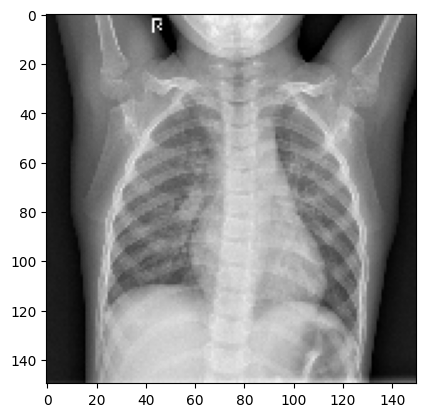

In [4]:
plt.imshow(X_train[0], cmap='gray')

In [5]:
# normalization

X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
X_val = np.array(X_val) / 255.0

X_train = X_train.reshape(-1, img_shape[0], img_shape[1], 1)
X_test = X_test.reshape(-1, img_shape[0], img_shape[1], 1)
X_val = X_val.reshape(-1, img_shape[0], img_shape[1], 1)

# pd.DataFrame(X[0])

In [6]:
# augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
)

datagen.fit(X_train)
# according to the doc, to use this we run datagen.flow() when we fit the model
# (check ImageDataGenerator above)

In [7]:
# hyperparameters

epochs = 20

In [8]:
model = keras.models.Sequential()

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape =(150,150,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.15, min_lr=0.000001)
training = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = epochs, validation_data = datagen.flow(X_val, y_val) ,callbacks = [lr_reduction])


print(f"LOSS: {model.evaluate(X_test, y_test)[0]}")
print(f"ACCURACY: {model.evaluate(X_test, y_test)[1] * 100}%")

model.save("./saved_models/model23.keras")


# Simplest model i came up with. performing the best so far. got accuracy bn 88-92.4,
# but it seems to fluctuate a bit
# could add more epochs or early stopping or sth to get the best out of it

2024-01-22 15:58:01.917093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 15:58:01.961534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 15:58:01.961605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 15:58:01.965660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 15:58:01.965925: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 75, 75, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                        

2024-01-22 15:58:04.575548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-22 15:58:04.823576: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-22 15:58:05.202754: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-22 15:58:07.186750: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-22 15:58:08.356972: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7ee455b6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 15:58:08.357022: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 10

131/131 [==============================] - 29s 159ms/step - loss: 0.3583 - accuracy: 0.8447 - val_loss: 1.9130 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 20s 152ms/step - loss: 0.2655 - accuracy: 0.8855 - val_loss: 4.6551 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9027
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
131/131 [==============================] - 21s 157ms/step - loss: 0.2274 - accuracy: 0.9027 - val_loss: 4.3132 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 20s 153ms/step - loss: 0.1909 - accuracy: 0.9177 - val_loss: 1.9533 - val_accuracy: 0.7433 - lr: 1.5000e-04
Epoch 5/20
131/131 [==============================] - 20s 152ms/step - loss: 0.1743 - accuracy: 0.9241 - val_loss: 1.0227 - val_accuracy: 0.7683 - lr: 1.5000e-04
Epoch 6/20
131/131 [==============================] 

In [9]:
model = keras.models.Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape =(150,150,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (4,4), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.35, min_lr=0.000001)
training = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = epochs, validation_data = datagen.flow(X_val, y_val) ,callbacks = [lr_reduction])


print(f"LOSS: {model.evaluate(X_test, y_test)[0]}")
print(f"ACCURACY: {model.evaluate(X_test, y_test)[1] * 100}%")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                      

2024-01-22 16:05:34.476930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


131/131 [==============================] - 19s 94ms/step - loss: 0.3721 - accuracy: 0.8182 - val_loss: 1.1495 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 12s 92ms/step - loss: 0.2933 - accuracy: 0.8674 - val_loss: 1.6799 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.8972
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.
131/131 [==============================] - 13s 100ms/step - loss: 0.2569 - accuracy: 0.8972 - val_loss: 1.1943 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 11s 82ms/step - loss: 0.2031 - accuracy: 0.9160 - val_loss: 1.0192 - val_accuracy: 0.7481 - lr: 3.5000e-04
Epoch 5/20
131/131 [==============================] - 11s 82ms/step - loss: 0.1962 - accuracy: 0.9170 - val_loss: 0.2266 - val_accuracy: 0.9240 - lr: 3.5000e-04
Epoch 6/20
131/131 [==============================] - 1

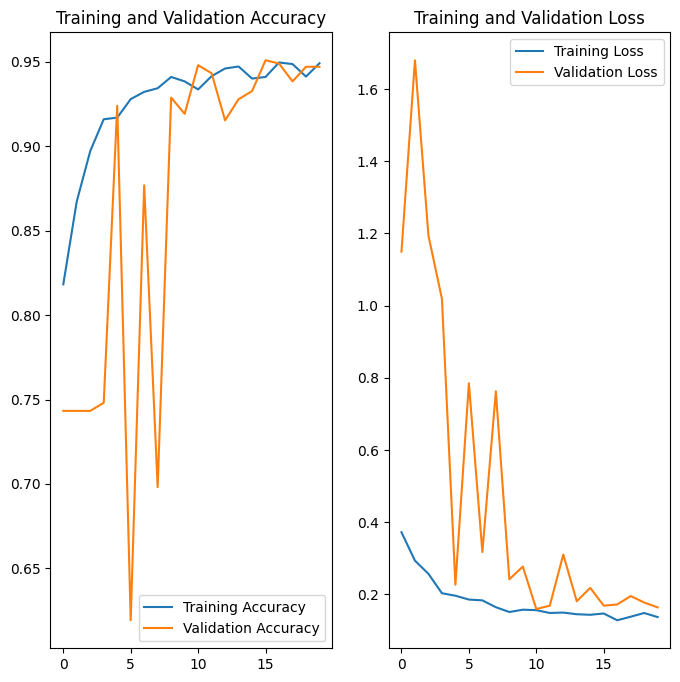

In [10]:
# testing accuracy in output of cell above

acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()